Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 102ms/step - loss: 0.2795 - val_loss: 0.1223
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.1205 - val_loss: 0.1131
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - loss: 0.1130 - val_loss: 0.1092
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.1094 - val_loss: 0.1066
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - loss: 0.1073 - val_loss: 0.1051
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.1058 - val_loss: 0.1038
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 0.1046 - val_loss: 0.1029
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - loss: 0.1035 - val_loss: 0.1021
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step - loss: 0.1030 - val_loss: 0.1014
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - loss: 0.1023 - val_loss: 0.1015
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


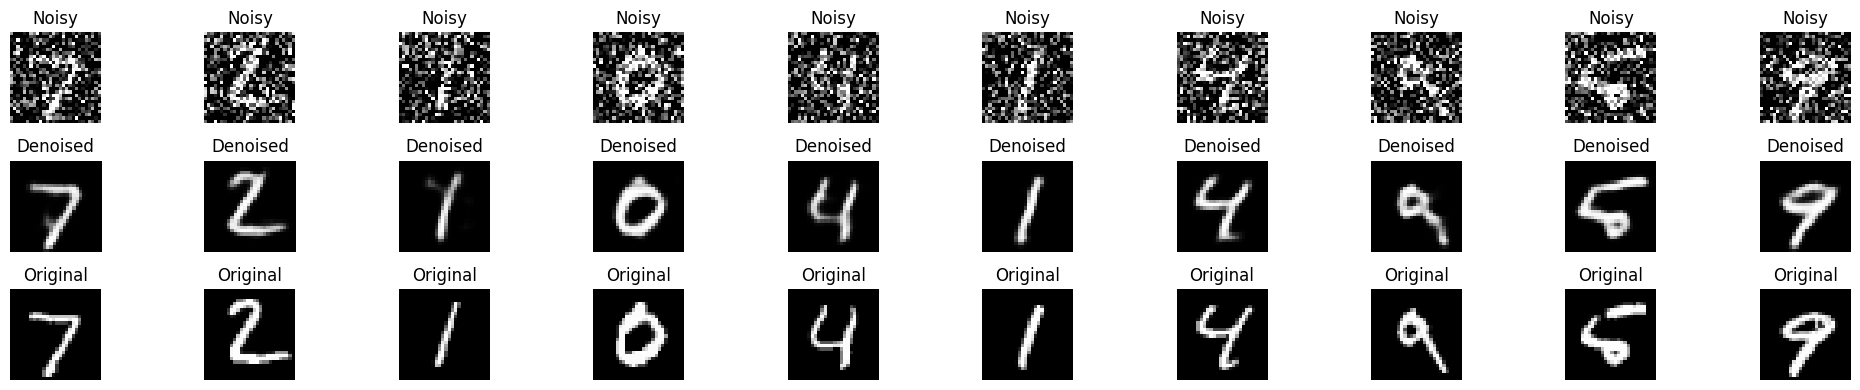

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Load and preprocess MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# We’re dividing the entire dataset into multiple batches to train the model more efficiently
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise
noise_factor = 0.5
x_train_noisy = np.clip(x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape), 0., 1.)

# Convolutional Autoencoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

# Predict
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.set_title("Noisy")
    ax.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_title("Denoised")
    ax.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.set_title("Original")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# Evaluate PSNR and SSIM on a few samples
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

num_samples = 10
total_psnr = 0
total_ssim = 0

for i in range(num_samples):
    original = x_test[i].reshape(28, 28)
    denoised = decoded_imgs[i].reshape(28, 28)

    image_psnr = psnr(original, denoised)
    image_ssim = ssim(original, denoised, data_range=1.0)

    total_psnr += image_psnr
    total_ssim += image_ssim

    print(f"Image {i+1}: PSNR = {image_psnr:.2f}, SSIM = {image_ssim:.4f}")

# Print average scores
avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\n Average PSNR over {num_samples} images: {avg_psnr:.2f} dB")
print(f" Average SSIM over {num_samples} images: {avg_ssim:.4f}")


Image 1: PSNR = 20.96, SSIM = 0.8372
Image 2: PSNR = 18.97, SSIM = 0.8694
Image 3: PSNR = 22.25, SSIM = 0.7556
Image 4: PSNR = 17.85, SSIM = 0.8707
Image 5: PSNR = 19.57, SSIM = 0.8314
Image 6: PSNR = 23.73, SSIM = 0.9369
Image 7: PSNR = 20.64, SSIM = 0.8668
Image 8: PSNR = 18.61, SSIM = 0.8146
Image 9: PSNR = 18.26, SSIM = 0.8591
Image 10: PSNR = 19.44, SSIM = 0.8867

 Average PSNR over 10 images: 20.03 dB
 Average SSIM over 10 images: 0.8528
